##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2|.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Universal Sentence Encoder

Note: You can run this notebook [live in Colab](https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/semantic_similarity_with_tf_hub_universal_encoder.ipynb) with zero setup.

This notebook illustrates how to access the Universal Sentence Encoder and use it for sentence similarity and sentence classification tasks.

The Universal Sentence Encoder makes getting sentence level embeddings as easy as it has historically been to lookup the embeddings for individual words. The sentence embeddings can then be trivially used to compute sentence level meaning similarity as well as to enable better performance on downstream classification tasks using less supervised training data.


# Getting Started

This section sets up the environment for access to the Universal Sentence Encoder on TF Hub and provides examples of applying the encoder to words, sentences, and paragraphs.

In [2]:
# Install the latest Tensorflow version.
!pip3 install --quiet "tensorflow>=1.7"
# Install TF-Hub.
!pip3 install --quiet tensorflow-hub

More detailed information about installing Tensorflow can be found at [https://www.tensorflow.org/install/](https://www.tensorflow.org/install/).

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

In [2]:
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/1")

# Compute a representation for each message, showing various lengths supported.
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")
messages = [word, sentence, paragraph]

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  message_embeddings = session.run(embed(messages))

  for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
    print("Message: {}".format(messages[i]))
    print("Embedding size: {}".format(len(message_embedding)))
    message_embedding_snippet = ", ".join(
        (str(x) for x in message_embedding[:3]))
    print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/1'.
INFO:tensorflow:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/1'.
INFO:tensorflow:Initialize variable module/Embeddings_en/sharded_0:0 from checkpoint b'/tmp/tfhub_modules/c6f5954ffa065cdb2f2e604e740e8838bf21a2d3/variables/variables' with Embeddings_en/sharded_0
INFO:tensorflow:Initialize variable module/Embeddings_en/sharded_1:0 from checkpoint b'/tmp/tfhub_modules/c6f5954ffa065cdb2f2e604e740e8838bf21a2d3/variables/variables' with Embeddings_en/sharded_1
INFO:tensorflow:Initialize variable module/Embeddings_en/sharded_10:0 from checkpoint b'/tmp/tfhub_modules/c6f5954ffa065cdb2f2e604e740e8838bf21a2d3/variables/variables' with Embeddings_en/sharded_10
INFO:tensorflow:Initialize variable module/Embeddings_en/sharded_11:0 from checkpoint b'/tmp/tfhub_modules/c6f5954ffa065cdb2f2e604e740e8838bf21a2d3/var

# Semantic Textual Similarity Task Example

The embeddings produced by the Universal Sentence Encoder are approximately normalized. The semantic similarity of two sentences can be trivially computed as the inner product of the encodings.

In [3]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")


def run_and_plot(session_, input_tensor_, messages_, encoding_tensor):
  message_embeddings_ = session_.run(
      encoding_tensor, feed_dict={input_tensor_: messages})
  plot_similarity(messages_, message_embeddings_, 90)

## Similarity Visualized
Here we show the similarity in a heat map. The final graph is a 9x9 matrix where each entry `[i, j]` is colored based on the inner product of the encodings for sentence `i` and `j`.

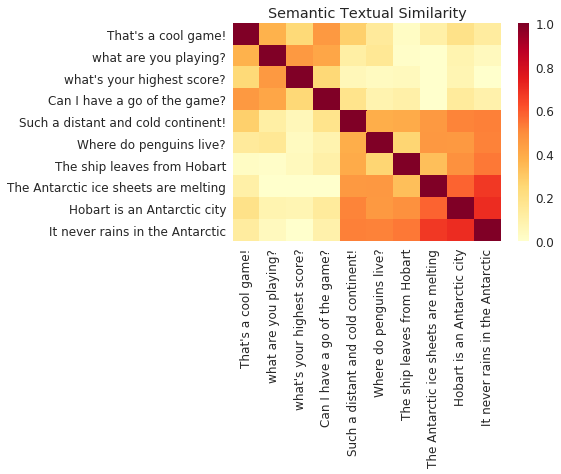

In [4]:
messages = [
    # Smartphones
#     "I like my phone",
#     "My phone is not good.",
#     "Your cellphone looks great.",

#     # Weather
#     "Will it snow tomorrow?",
#     "Recently a lot of hurricanes have hit the US",
#     "Global warming is real",

#     # Food and health
#     "An apple a day, keeps the doctors away",
#     "Eating strawberries is healthy",
#     "Is paleo better than keto?",

#     # Asking about age
#     "How old are you?",
#     "what is your age?",

    # Asking about games
    "That's a cool game!",
    "what are you playing?",
    "what's your highest score?",
    "Can I have a go of the game?",

    # Asking about bodies
#     "That feels nice!",
#     "Do it again!",
#     "Let's go to bed",
#     "Can I have a kiss?",

    # Asking about Antarctica
    "Such a distant and cold continent!",
    "Where do penguins live?",
    "The ship leaves from Hobart",
    "The Antarctic ice sheets are melting",

    # Asking about Antarctica
    "Hobart is an Antarctic city",
    "It never rains in the Antarctic",
]

similarity_input_placeholder = tf.placeholder(tf.string, shape=(None))
similarity_message_encodings = embed(similarity_input_placeholder)
with tf.Session() as session:
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  run_and_plot(session, similarity_input_placeholder, messages,
               similarity_message_encodings)

## Evaluation: STS (Semantic Textual Similarity) Benchmark

The [**STS Benchmark**](http://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark) provides an intristic evaluation of the degree to which similarity scores computed using sentence embeddings align with human judgements. The benchmark requires systems to return similarity scores for a diverse selection of sentence pairs. [Pearson correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) is then used to evaluate the quality of the machine similarity scores against human judgements.

### Download data

In [5]:
import pandas
import scipy
import math


def load_sts_dataset(filename):
  # Loads a subset of the STS dataset into a DataFrame. In particular both
  # sentences and their human rated similarity score.
  sent_pairs = []
  with tf.gfile.GFile(filename, "r") as f:
    for line in f:
      ts = line.strip().split("\t")
      # (sent_1, sent_2, similarity_score)
      sent_pairs.append((ts[5], ts[6], float(ts[4])))
  return pandas.DataFrame(sent_pairs, columns=["sent_1", "sent_2", "sim"])


def download_and_load_sts_data():
  sts_dataset = tf.keras.utils.get_file(
      fname="Stsbenchmark.tar.gz",
      origin="http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz",
      extract=True)

  sts_dev = load_sts_dataset(
      os.path.join(os.path.dirname(sts_dataset), "stsbenchmark", "sts-dev.csv"))
  sts_test = load_sts_dataset(
      os.path.join(
          os.path.dirname(sts_dataset), "stsbenchmark", "sts-test.csv"))

  return sts_dev, sts_test


sts_dev, sts_test = download_and_load_sts_data()

417792/409630 [==============================] - 3s 6us/step


### Build Evaluation Graph

In [6]:
text_a = sts_dev['sent_1'].tolist()
text_b = sts_dev['sent_2'].tolist()
dev_scores = sts_dev['sim'].tolist()
sts_input1 = tf.placeholder(tf.string, shape=(None))
sts_input2 = tf.placeholder(tf.string, shape=(None))

# For evaluation we use exactly normalized rather than
# approximately normalized.
sts_encode1 = tf.nn.l2_normalize(embed(sts_input1))
sts_encode2 = tf.nn.l2_normalize(embed(sts_input2))
sim_scores = tf.reduce_sum(tf.multiply(sts_encode1, sts_encode2), axis=1)

### Evaluate Sentence Embeddings

In [7]:
def run_sts_benchmark(session):
  """Returns the similarity scores"""
  emba, embb, scores = session.run(
      [sts_encode1, sts_encode2, sim_scores],
      feed_dict={
          sts_input1: text_a,
          sts_input2: text_b
      })
  return scores


with tf.Session() as session:
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  scores = run_sts_benchmark(session)

pearson_correlation = scipy.stats.pearsonr(scores, dev_scores)
print('Pearson correlation coefficient = {0}\np-value = {1}'.format(
    pearson_correlation[0], pearson_correlation[1]))

Pearson correlation coefficient = 0.7513779554771468
p-value = 9.744174530826099e-273
